In [1]:
# Here, Z is converted into solar units:
#     Z_sim is in mass fraction units
#     Z_arr = Z_sim/0.02
#     kappa = 1000*m_p*Z_arr  --> in n_LW & n_LW_ss
#     denominator = CC * Z_arr * n_H  --> in X_H2
#     n_CO = 1e-4*n_H*X_CO*Z_arr
#     5kpc

In [2]:
%matplotlib inline

#import sys
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import matplotlib.colors as cm
import pynbody
from michaels_functions import center_and_r_vir, remove_bulk_velocity
from matplotlib.colors import LogNorm
from matplotlib.pyplot import figure

In [3]:
path = "bulk1/data_2/hydro_59/output/"
data = pynbody.load(path + "output_00050")
aexp = data.properties['a']
data.physical_units()
r_vir = center_and_r_vir(data, aexp, path)
remove_bulk_velocity(data)
r_e = 0.1 * r_vir
sph_5 = pynbody.filt.Sphere(radius = '5.0 kpc') # %(r_e*1.4))
region = data[sph_5]
rho = region.gas["rho"].in_units("m_p cm**-3")
f = open(data.filename + "/info_"+data.filename[-5:]+".txt","r")
lines = f.readlines()
f.close()
for line in lines:
    if line[0:13]=="unit_l      =":
        print line[:-1]
        unit_l = float(line[14:-1])
    if line[0:13]=="unit_d      =":
        print line[:-1]
        unit_d = float(line[14:-1])
    if line[0:13]=="unit_t      =":
        print line[:-1]
        unit_t = float(line[14:-1])
    if line[0:13]=="omega_b     =":
        print line[:-1]
        omega_b = float(line[14:-1])

('shifting on Stars:', SimArray([ 0.00308878, -0.03302971, -0.04676732], 'kpc'))
('virial radius:', SimArray(152.40432611, 'kpc'))
omega_b     =  0.450000017881393E-01
unit_l      =  0.682025380323961E+26
unit_d      =  0.123367583719985E-28
unit_t      =  0.163687521954501E+18


In [4]:
m_p = pynbody.array.SimArray(1.672621777e-24, "g")
K_b = pynbody.array.SimArray(1.38064852e-16, "cm**2 g s**-2 K**-1")
G = pynbody.array.SimArray(6.67259e-8, "cm**3 g**-1 s**-2")
T_mean = pynbody.array.SimArray(10., "K")
K_b_ev = pynbody.array.SimArray(8.617e-5, "eV K**-1")
c_si = pynbody.array.SimArray(2.99792458e5, "km s**-1")
c_cgs = pynbody.array.SimArray(2.99792458e10, "cm s**-1")
h_ev = pynbody.array.SimArray(4.13566770e-15, "eV s")
mH_cgs = pynbody.array.SimArray(1.6737236e-24, 'g')  # hydrogen mass
T_bg = pynbody.array.SimArray(2.73, "K")
eV = pynbody.array.SimArray(6.241509e18, "J")
L_sun = pynbody.array.SimArray(2.3892497766e+47, "eV s**-1")

In [5]:
def get_filename(species):
    # filename is already given
    if (species[-4:] == '.dat') or (species[-4:] == '.txt'):
        return species
    # molecule is chosen
    THIS_FOLDER = os.path.dirname(os.path.abspath(__file__))
    database = os.path.join(THIS_FOLDER, 'LAMDA')
    if species == 'HCO+':
        filename = os.path.join(database, 'HCO+.dat')
    elif species == 'H13CO+':
        filename = os.path.join(database, 'H13CO+.dat')
    elif species == 'N2H+':
        filename = os.path.join(database, 'N2H+.dat')
    elif species == 'SiO':
        filename = os.path.join(database, 'SiO.dat')
    elif species == 'HNC':
        filename = os.path.join(database, 'HNC.dat')
    elif species == 'HCN':
        filename = os.path.join(database, 'HCN.dat')
    elif species == 'CO':
        filename = os.path.join(database, 'CO.dat')
    else:
        print('Unknow species. Chose from HCO+, H13CO+, N2H+, SiO, HNC, HCN, CO')
        print('or provide a LAMDA datafile.')
        exit()

    return filename

def read_file(species, c_cgs, h_ev, K_b_ev):
    filename = get_filename(species)
    f = open(filename, 'r')

    f.readline()
    species = f.readline()

    f.readline()
    mu = float(f.readline())  # molecular weight

    f.readline()
    num_lvls = int(f.readline())  # number of energy levels

    # read energy levels: energy E, statistical weight g
    f.readline()
    E = []
    g = []
    for l in range(num_lvls):
        words = f.readline().split()
        E.append(float(words[1]) *c_cgs*h_ev) # cm^-1 -> eV
        g.append(float(words[2]))

    f.readline()
    num_trans = int(f.readline())  # number of radiative transistions

    # read transistions: upper lvl, lower lvl, A-coefficient, frequency
    f.readline()
    A = np.zeros((num_lvls, num_lvls))
    freq = np.zeros((num_lvls, num_lvls))
    for t in range(num_trans):
        words = f.readline().split()
        up = int(words[1]) - 1
        low = int(words[2]) - 1
        if up-low==1:
            A[up][low] = float(words[3])  # s^-1
            freq[up][low] = float(words[4]) * 1e9  # GHz -> Hz
            #freq[low][up] = freq[up][low] #un-comment this only if low->up transitions are also allowed

    # compute B-coefficient via Einstein relations
    # Bij = coeff for stimulated emission, Bji = coeff for extinction (j<i)
    B = np.zeros((num_lvls, num_lvls))
    for i in range(0, num_lvls):
        for j in range(0, i):
            if A[i][j] != 0:
                B[i][j] = A[i][j] * (c_cgs**2) / (2*h_ev * (freq[i][j])**3) # cm2/(eV*s)
                B[j][i] = B[i][j] * g[i]/g[j]

    # number of collision partners in the data file
    f.readline()
    num_partners = int(f.readline())

    C_all = []
    temps_all = []
    for partner in range(num_partners):
        # reference
        f.readline()
        line = f.readline()

        # number of collisional transitions
        f.readline()
        num_coll = int(f.readline())

        # number of temperatures in the table
        f.readline()
        num_temps = int(f.readline())

        # read the temperature values
        f.readline()
        words = f.readline().split()
        temps = np.zeros(num_temps)
        for t in range(num_temps):
            temps[t] = float(words[t])
            temps_all.append(temps)  # K

        # read collision coeff data: upper lvl, lower lvl, C-coefficient for each temp
        C = np.zeros((num_temps, num_lvls, num_lvls))
        f.readline()
        for col in range(num_coll):
            words = f.readline().split()
            i = int(words[1]) - 1
            j = int(words[2]) - 1
            for t in range(num_temps):
                C[t][i][j] = float(words[3+t]) #* 1.e-6 # cm3/s -> m3/s

        # calculate the inverse coefficient via LTE relation
        for i in range(num_lvls):
            for j in range(i):
                for t in range(num_temps):
                    if C[t][i][j] != 0:
                        C[t][j][i] = C[t][i][j] * np.exp(-(E[i]-E[j])/(K_b_ev*temps[t]))*g[i]/g[j]

        # add collision partner data to global array
        C_all.append(C)

    f.close()
    C_all = np.array(C_all) #cm3/s
    temps_all = np.array(temps_all) #K
    E = np.array(E) #eV
    g = np.array(g) 
    freq = np.array(freq) #Hz
    A = np.array(A) #s-1
    B = np.array(B) #cm2/(eV*s)
    return mu, num_lvls, E, g, freq, A, B, C_all, num_partners, temps_all, num_temps, num_coll

def partion_function(T, num_lvls, g, E):
    Z=0.0
    for i in range(0,num_lvls):
        Z = Z + g[i]*np.exp(-E[i]/(K_b_ev*T))
    return np.array(Z)

def calc_lvlpops_partion(T, num_lvls, g, E):
    ni = np.zeros(num_lvls)
    Z = partion_function(T, num_lvls, g, E)
    for i in range(0, num_lvls):
        ni[i] = g[i]*np.exp(-E[i]/(K_b_ev*T)) / Z
    return np.array(ni), Z

In [6]:
mu, num_lvls, E, g, freq, A, B, C_all, num_partners, temps_all, num_temps, n_coll = read_file('CO.txt',c_cgs, h_ev, K_b_ev)





In [7]:
ni, Z = calc_lvlpops_partion(T_mean, num_lvls, g, E)
c_s_CO = np.sqrt(K_b * T_mean/(mH_cgs*mu))

In [8]:
u = 1 #upper level
l = 0 #lower level
nu = pynbody.array.SimArray(freq[u][l], "Hz")
n_i = ni[u]
n_j = ni[l]
A_ij = A[u][l]
B_ij = B[u][l]
B_ji = B[l][u]

In [32]:
X_H2_bar = pynbody.array.SimArray(np.load('radiative_transfer/outputs_RT/1.3/X_H2_bar_1.3.npy'),
                                  units = "1")
X_CO_bar = pynbody.array.SimArray(np.load('radiative_transfer/outputs_RT/1.3/X_CO_bar_1.3.npy'),
                                  units = "1")
mach_no_arr = np.load('radiative_transfer/outputs_RT/1.3/mach_no_arr_1.3.npy')
n_H_mean_arr = pynbody.array.SimArray(np.load('radiative_transfer/outputs_RT/1.3/n_H_mean_arr_1.3.npy'),
                                      units = "cm**-3")
metal_arr = np.load('radiative_transfer/outputs_RT/1.3/metal_arr_1.3.npy')
temperature = pynbody.array.SimArray(np.load('radiative_transfer/outputs_RT/1.3/T_1.3.npy'),
                                     units = "K")
j_10_bar = pynbody.array.SimArray(np.load('radiative_transfer/outputs_RT/1.3/j_nu_bar_1.3.npy'), 
                                  units = "eV cm**-3 s**-1")
cell_dim = region.gas["smooth"]

In [33]:
region.gas["X_H2_bar"] = X_H2_bar
region.gas["X_CO_bar"] = X_CO_bar
region.gas["n_H_mean_arr"] = n_H_mean_arr
region.gas["mach_no_arr"] = mach_no_arr
region.gas["metal_arr"] = metal_arr
region.gas["j_10_bar"] = j_10_bar


/home/cluster/mkrets/anaconda2/lib/python2.7/site-packages/pynbody-0.47-py2.7-linux-x86_64.egg/pynbody/snapshot/__init__.py:1443: RuntimeWarning: Conjoining derived and non-derived arrays. Assuming result is non-derived, so no further updates will be made.
  "Conjoining derived and non-derived arrays. Assuming result is non-derived, so no further updates will be made.", RuntimeWarning)


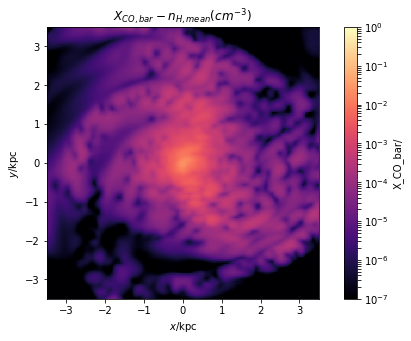

CPU times: user 24.4 s, sys: 5.12 s, total: 29.5 s
Wall time: 14.8 s


In [12]:
%%time
plt.figure(figsize=(9,5))
pynbody.plot.image(region.g, qty="X_CO_bar", width='7.0 kpc',
                   log=True, resolution=500, cmap="magma", av_z="n_H_mean_arr",
                  vmin = 1e-7, vmax = 1.0)
plt.title("$X_{CO, bar}-n_{H, mean}(cm^{-3})$")
plt.show()


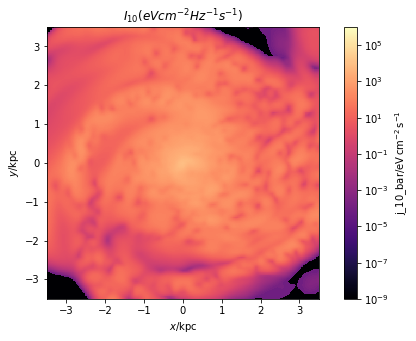

In [35]:
plt.figure(figsize=(9,5))
pynbody.plot.image(region.g, qty="j_10_bar", width='7.0 kpc', units="eV cm**-2 s**-1",
                   log=True, resolution=500, cmap="magma",
                         vmin = 1e-9, vmax = 1e6)
plt.title("$I_{10} (eV cm^{-2} Hz^{-1} s^{-1})$")
#plt.savefig('outputs/3.8/X_H2_bar-n_H_mean-3.8.png', dpi=300, bbox_inches='tight')
plt.show()


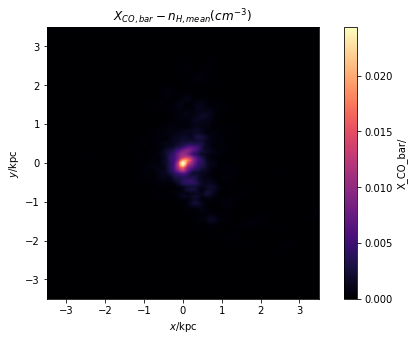

CPU times: user 18.6 s, sys: 2.33 s, total: 21 s
Wall time: 6.99 s


In [15]:
%%time
plt.figure(figsize=(9,5))
pynbody.plot.image(region.g, qty="X_CO_bar", width='7.0 kpc',
                   log=False, resolution=500, cmap="magma", av_z="n_H_mean_arr")
plt.title("$X_{CO, bar}-n_{H, mean}(cm^{-3})$")
plt.show()

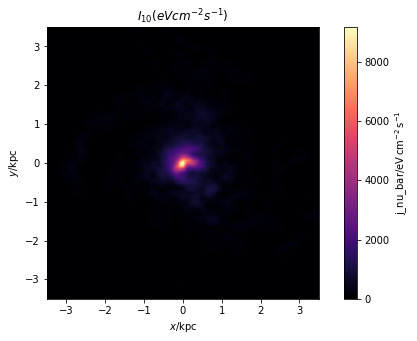

In [36]:
plt.figure(figsize=(9,5))
I_10 = pynbody.plot.image(region.g, qty="j_nu_bar", width='7.0 kpc', units="eV cm**-2 s**-1",
                   log=False, resolution=500, cmap="magma")
plt.title("$I_{10} (eV cm^{-2} s^{-1})$")
plt.show()


In [53]:
def calc_temp_for_rad_field(nu, I_nu):
    delta_v = pynbody.array.SimArray(100, "km s**-1")
    T_nu_prime = (c_cgs**2)*I_nu / ( 2*(nu**2) * K_b_ev)
    T_nu = T_nu_prime * c_si / delta_v
    #units: cm**2 s**-2 * eV cm**-2 Hz**-1 s**-1 * Hz**-2 * eV**-1 K = K Hz**-3 s**-3 = K
    return delta_v, T_nu_prime, T_nu



In [37]:
np.min(I_10)

SimArray(0., dtype=float32, 'eV cm**-2 s**-1')

In [38]:
np.max(I_10)

SimArray(9167.852, dtype=float32, 'eV cm**-2 s**-1')

In [39]:
np.min(j_10_bar)

SimArray(0., 'eV cm**-3 s**-1')

In [40]:
np.max(j_10_bar)

SimArray(4.04322086e-17, 'eV cm**-3 s**-1')

In [41]:
I_nu = I_10/nu

In [42]:
np.min(I_nu)

SimArray(0., dtype=float32, 'eV s**-1 Hz**-1 cm**-2')

In [43]:
np.max(I_nu)

SimArray(7.953289e-08, dtype=float32, 'eV s**-1 Hz**-1 cm**-2')

In [65]:
delta_v, T_nu_prime, T_nu = calc_temp_for_rad_field(nu, I_nu)
T_nu = pynbody.array.SimArray(T_nu, "K")
T_nu_prime = pynbody.array.SimArray(T_nu_prime, "K")

In [66]:
np.min(T_nu)

SimArray(0., dtype=float32, 'K')

In [67]:
np.max(T_nu)

SimArray(0.09357959, dtype=float32, 'K')

In [94]:
np.mean(T_nu)

SimArray(0.0012553, dtype=float32, 'K')

In [68]:
np.min(T_nu_prime)

SimArray(0., dtype=float32, 'K')

In [69]:
np.max(T_nu_prime)

SimArray(3.121479e-05, dtype=float32, 'K')

In [70]:
delta_v

SimArray(100, 'km s**-1')

In [75]:
L_CO = T_nu_prime * c_si

In [76]:
np.min(L_CO)

SimArray(0., dtype=float32, 'K km s**-1')

In [77]:
np.max(L_CO)

SimArray(9.357959, dtype=float32, 'K km s**-1')

In [84]:
abc = I_nu * c_si

In [85]:
np.min(abc)

SimArray(0., dtype=float32, 'eV km Hz**-1 s**-2 cm**-2')

In [86]:
np.max(abc)

SimArray(0.02384336, dtype=float32, 'eV km Hz**-1 s**-2 cm**-2')

In [87]:
r_e_pc = pynbody.array.SimArray(r_e * 1e3, "pc")
r_e_pc

SimArray(15240.43261115, 'pc')

In [93]:
foo = np.sum(abc*(r_e_pc**2))
foo

SimArray(1.8572376e+10, dtype=float32, 'pc**2 km eV Hz**-1 s**-2 cm**-2')

In [79]:
L_CO_galaxy = np.sum(L_CO*(r_e_pc**2))
L_CO_galaxy

SimArray(7.2892206e+12, dtype=float32, 'pc**2 K km s**-1')

/net/cephfs/home/mkrets/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


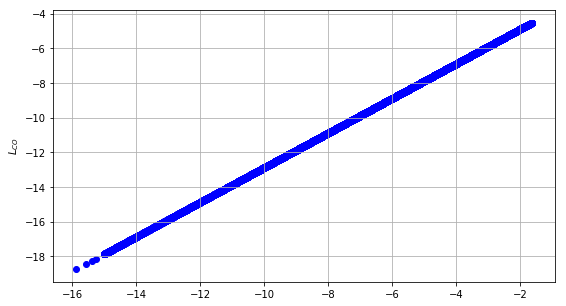

In [164]:
plt.figure(figsize=(9,5))
ax = plt.gca()
plt.scatter(np.log10(L_CO), np.log10(temp_for_rad_field), c="b")
#ax.set_xlim([xmin,xmax])
#ax.set_ylim([0,1.25e-22])
#plt.xlabel('no. of pixels on the map')
plt.ylabel('$L_{CO}$')
plt.grid(b=True, which='both', axis='both')

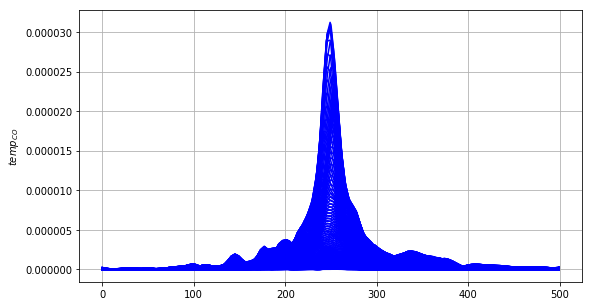

In [161]:
plt.figure(figsize=(9,5))
ax = plt.gca()
plt.plot(temp_for_rad_field, c="b")
#ax.set_xlim([xmin,xmax])
#ax.set_ylim([0,1.25e-22])
#plt.xlabel('no. of pixels on the map')
plt.ylabel('$temp_{CO}$')
plt.grid(b=True, which='both', axis='both')